In [18]:
import torch
import os
import numpy as np
import re
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import json

def checkpoint_epoch(folder, epoch=19):
    files = os.listdir(folder)
    f = [f for f in files if "batches_{}_.pth".format(epoch) in f]
    if len(f) > 0:
        return f[0]
    return -1

def add_metadata(fname, d):
    match = re.search('width_mult_\d+(\.\d+)?', fname)
    if match:
        width_mult = match.group(0)[len("width_mult_"):]
        d["width_mult"] = float(width_mult)
    match = re.search('-lr_\d+.\d+', fname)
    if match:
        value = match.group(0)[len("-lr_"):]
        d["lr"] = float(value)
    match = re.search('-depth_mult_\d+', fname)
    if match:
        value = match.group(0)[len("-depth_mult_"):]
        d["depth_mult"] = int(value)
    match = re.search('-parametr_mup_depth', fname)
    if match:
        d["mup_depth"] = True
    else:
        d["mup_depth"] = False
        
    match = re.search('skip_scaling_\d+(\.\d+)?', fname)
    if match:
        value = match.group(0)[len("skip_scaling_"):]
        d["skip_scaling"] = float(value)
    else:
        d["skip_scaling"] = 1.0
    
    match = re.search('res_scaling_\d+(\.\d+)?', fname)
    if match:
        value = match.group(0)[len("res_scaling_"):]
        d["res_scaling"] = float(value)
    else:
        d["res_scaling"] = 1.0
    
    match = re.search('epoch_\d+', fname)
    if match:
        width_mult = match.group(0)[len("epoch_"):]
        d["epochs"] = int(width_mult)
        
    match = re.search('seed_\d+', fname)
    if match:
        s = match.group(0)[len("seed_"):]
        d["seed"] = int(s)
    else:
        d["seed"] = None
    
    match = re.search('beta_\d+(\.\d+)?', fname)
    if match:
        value = match.group(0)[len("beta_"):]
        d["beta"] = float(value)
    else:
        d["beta"] = 1.0
    
    match = re.search('gamma_zero_\d+(\.\d+)?', fname)
    if match:
        value = match.group(0)[len("gamma_zero_"):]
        d["gamma_zero"] = float(value)
    else:
        d["gamma_zero"] = 1.0
        
    match = re.search('-norm_ln', fname)
    if match:
        d["norm"] = "ln"
    elif re.search('-norm_bn', fname):
        d["norm"] = "ln"
    elif re.search('-norm_None', fname):
        d["norm"] = None
    else:
        d["norm"] = None
    
    match = re.search('k_layers_\d+', fname)
    if match:
        value = match.group(0)[len("k_layers_"):]
        d["k_layers"] = int(value)
    else:
        d["k_layers"] = None
        
    match = re.search('batch_size_\d+', fname)
    if match:
        value = match.group(0)[len("batch_size_"):]
        d["batch_size"] = int(value)
    else:
        d["batch_size"] = None
    return d


def get_data(folder_path, epoch=19):
    final_d = []
    for fp in os.listdir(folder_path):
        fpath = os.path.join(folder_path, fp)
        d_file = checkpoint_epoch(fpath, epoch=epoch)
        if d_file != -1:
            fpath_ = os.path.join(fpath, checkpoint_epoch(fpath, epoch=epoch))
            d = torch.load(fpath_)
            d = add_metadata(fp, d)
            args_path = open(os.path.join(fpath, "args.json"))
            args = json.load(args_path)
            d["width"] = args["width"]
            d["name"] = fp
            final_d.append(d)
    return final_d


def loss_curves(run_ds, train=True, acc=True):
    ds = []
    for d in run_ds:
        loss_d = pd.DataFrame()
        try:
            if train:
                loss_d["train_loss"] =  d["metrics"]["train_loss"]
                if acc:
                    if "train_acc" in d["metrics"].keys():
                        loss_d["train_acc"] =  d["metrics"]["train_acc"]
                if "trace" in d["metrics"].keys() and len(d["metrics"]["trace"]) > 1:
                    loss_d["trace"] = d["metrics"]["trace"]
                if "top_eig" in d["metrics"].keys() and len(d["metrics"]["top_eig"]) > 1:
                    loss_d["top_eig"] = d["metrics"]["top_eig"]
            else:
                loss_d["test_loss"] =  d["metrics"]["test_loss"]
                loss_d["test_acc"] =  d["metrics"]["test_acc"]
            loss_d["lr"] = d["lr"]
            loss_d["width_mult"] = d["width_mult"]
            loss_d["width"] = d["width"]
            loss_d["depth_mult"] = d["depth_mult"]
            loss_d["step"] = loss_d.index
            loss_d["beta"] = d["beta"]
            loss_d["gamma_zero"] = d["gamma_zero"]
            loss_d["k_layers"] = d["k_layers"]
            loss_d["batch_size"] = d["batch_size"]
            loss_d["seed"] = d["seed"]
            ds.append(loss_d)
        except KeyError:
            continue
    return pd.concat(ds, axis=0)


def get_metrics_df(run_ds, metric):
    ds = []
    for d in run_ds:
        try:
            d[metric] = d['metrics'][metric][-1]
            d = {k: d[k] for k in (metric, 'lr', 'width_mult', 'depth_mult', 'mup_depth', 'norm', 'gamma_zero', 'beta', 'k_layers', 'batch_size','width', 'seed')}
            ds.append(d)
        except KeyError as e:
            print(e)
            continue
    return pd.DataFrame(ds)

/tmp/ipykernel_678154/2116630543.py:13: UserWarning: The palette list has more values (5) than needed (2), which may not be intended.
  sns.lineplot(data=df, x='lr', y=metric, hue="Width", marker='o', markersize=8, palette=sns.color_palette("viridis", n_colors=5), legend=True)


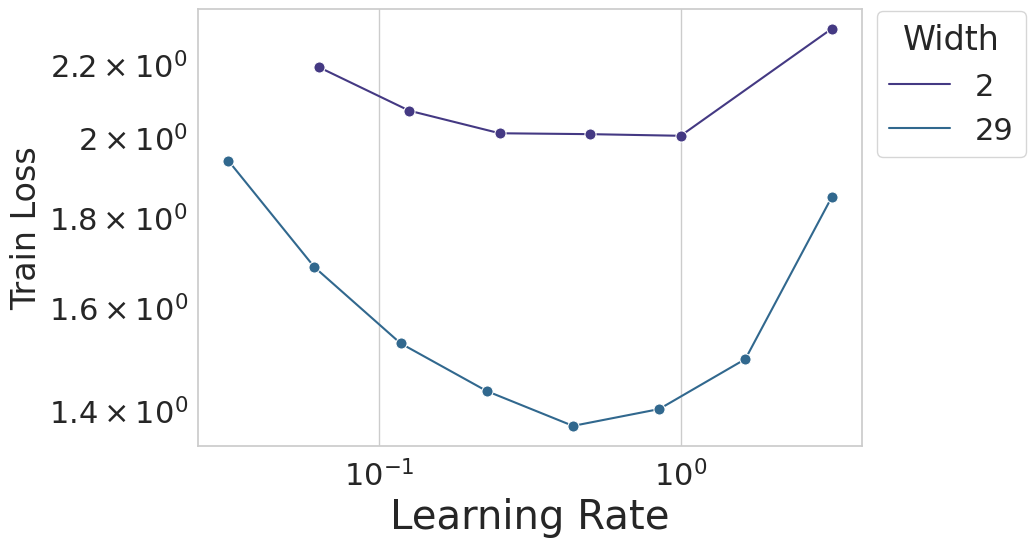

In [51]:
sns.set(style="whitegrid", font_scale=2, palette=sns.color_palette("viridis", n_colors=5))
plt.figure(figsize = (10,6))
folder_path = "/local/home/lnoci/nn_large_depth_width_landscape-1/experiments/convergence_optimal_lr"
metric = "train_loss"
run_ds = get_data(folder_path, epoch=10)
df = get_metrics_df(run_ds, metric)
#df = df[df["lr"] < 0.01]
#df["lr"] = df["lr"] * np.sqrt(df["depth"])
# df = df[df["depth"].isin([3, 6, 12, 30])]
df["Width"] = df["width"]
#df["Depth"] = df["depth_mult"] * 3

sns.lineplot(data=df, x='lr', y=metric, hue="Width", marker='o', markersize=8, palette=sns.color_palette("viridis", n_colors=5), legend=True)
plt.xscale("log")
plt.xlabel("Learning Rate", fontsize=29)

plt.ylabel("Train Loss")
#plt.legend(loc='lower left', title="Depth", fontsize=10)
plt.legend(bbox_to_anchor=(1.0, 1.03), loc='upper left', title="Width")
plt.tight_layout()
plt.yscale('log')
#plt.savefig("Figures/Rebuttal/cifar10_conv_hp_transfer_mup_width_data_augm_bs128.pdf", format='pdf', bbox_inches='tight')